In [64]:
import fact.io

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import astropy.units as u


from astropy.coordinates import Angle
from astropy.coordinates.angle_utilities import angular_separation

from scipy.stats import binned_statistic
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score



from spectrum import make_energy_bins

from tqdm import tqdm
%matplotlib inline

In [83]:
def plot_energy_resolution(e_true, e_reco, bins, ax=None, color='crimson'):
    if not ax :
        ax = plt.gca()
    resolution = (e_reco) / e_true

    iqr, bin_edges, binnumber = binned_statistic(e_reco, resolution, statistic=lambda y: ((np.percentile(y, 84) - np.percentile(y, 16)) / 2), bins=bins)

    label = '$IQR_{68}$ of $\\frac{E_R - E_T}{E_T}$'

    ax.hlines(iqr, bins[:-1], bins[1:], lw=2, color=color, label=label)

    path = '../resources/CTA-Performance-prod3b-v1-South-20deg-50h-Eres.txt'
    df = pd.read_csv(path, delimiter='\t\t', skiprows=11, names=['energy', 'resolution'], engine='python')
    ax.plot(df.energy, df.resolution, '--', color='#5b5b5b', label='Prod3B Reference')


    ax.set_xscale('log')

    ax.set_ylabel(label)
    ax.set_xlabel(r'$True Energy /  \mathrm{TeV}$')
    print(r2_score(e_true, e_reco))
    return ax

In [65]:
def calculate_theta(df, source_alt=70 * u.deg, source_az=0 * u.deg):
    source_az = Angle(source_az).wrap_at(180 * u.deg)
    source_alt = Angle(source_alt)

    az = Angle(df.az_prediction.values, unit=u.rad).wrap_at(180*u.deg)
    alt = Angle(df.alt_prediction.values, unit=u.rad)

    return angular_separation(source_az, source_alt, az, alt).to(u.deg).value


In [217]:
n_bins = 20

gamma_input = '../../cta_rta_analysis/build/gammas_train.hdf5'

e_min, e_max = 0.02 * u.TeV, 200 * u.TeV
bin_edges, bin_center, bin_width = make_energy_bins(e_min=e_min, e_max=e_max, bins=n_bins, centering='log')

gammas = fact.io.read_data(gamma_input, key='array_events',).set_index(['run_id', 'array_event_id'])
gammas['theta'] = calculate_theta(gammas)

gamma_tel_events = fact.io.read_data(gamma_input, key='telescope_events').set_index(['run_id', 'array_event_id'])
# gamma_tel_events.columns

In [219]:
col_ar = ['num_triggered_lst', 'num_triggered_mst', 'num_triggered_sst', 'num_triggered_telescopes', 'total_intensity']
col_tel = ['distance_to_core', 'r_over_f', 'focal_length', 'intensity', 'kurtosis', 'length', 'psi', 'r', 'skewness', 'telescope_type_id', 'width']


gamma_tel_events['r_over_f'] = gamma_tel_events.r / gamma_tel_events.focal_length

cols = ['mc_energy'] + col_ar
df = gamma_tel_events[['telescope_type_name'] + col_tel].merge(gammas[cols], left_index=True, right_index=True).dropna()
df.head()
# df = df.query('num_triggered_telescopes >= 5')

telescope_type_name  distance_to_core  r_over_f  \
run_id array_event_id                                                   
112    609                            LST         39.446186  0.018734   
       609                            LST        138.622653  0.019171   
       2302                           SST        186.337625  0.018477   
       2302                           SST        187.153843  0.020970   
       2302                           MST        182.621525  0.030432   

                       focal_length   intensity  kurtosis    length       psi  \
run_id array_event_id                                                           
112    609                     28.0   75.900832  2.022525  0.033484  1.788886   
       609                     28.0   83.632463  1.812221  0.059637  1.008087   
       2302                     5.6   53.631383  2.517533  0.024514 -3.015368   
       2302                     5.6   60.306017  2.135327  0.031168 -3.123992   
       2302                    16.0  219.142881  2.507825  0.091088  0.951692   

                              r  skewness  telescope_type_id     width  \
run_id array_event_id                                                    
112    609             0.524553  0.100451                  1  0.018199   
       609             0.536802 -0.117134                  1  0.019394   
       2302            0.103469  0.606872                  3  0.007546   
       2302            0.117432 -0.222521                  3  0.010970   
       2302            0.486907 -0.086248                  2  0.023905   

                       mc_energy  num_triggered_lst  num_triggered_mst  \
run_id array_event_id                                                    
112    609              0.019663                  2                  0   
       609              0.019663                  2                  0   
       2302             0.467354                  0                  5   
       2302             0.467354                  0                  5   
       2302             0.467354                  0                  5   

                       num_triggered_sst  num_triggered_telescopes  \
run_id array_event_id                                                
112    609                             0                         3   
       609                             0                         3   
       2302                            3                         8   
       2302                            3                         8   
       2302                            3                         8   

                       total_intensity  
run_id array_event_id                   
112    609                  159.533295  
       609                  159.533295  
       2302                2334.116164  
       2302                2334.116164  
       2302                2334.116164

(61134, 16) (61134,)
(129237, 16) (129237,)
(55690, 16) (55690,)


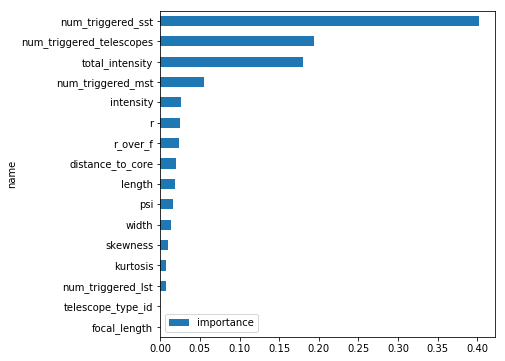

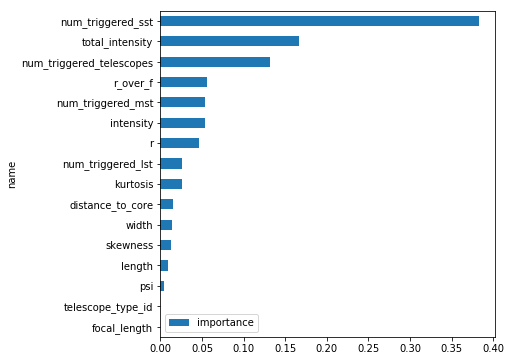

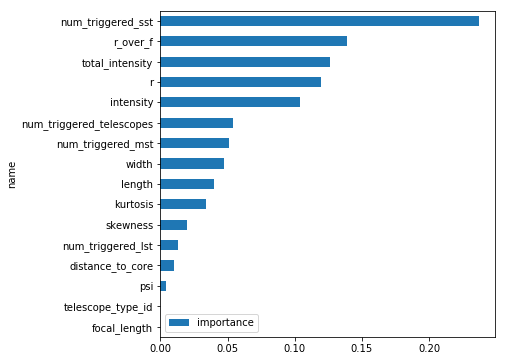

In [225]:
results = {}

for n, g in df.groupby('telescope_type_name'):
    print(n)
    X_train, X_test, y_train, y_test = train_test_split(g[col_ar + col_tel], g.mc_energy, test_size=0.33, shuffle=False)
    print(X_train.shape, y_train.shape)
    rf = RandomForestRegressor(n_estimators=250, min_samples_leaf=4, n_jobs=20, max_features='sqrt')
    rf.fit(X_train, y_train)
    e_reco = rf.predict(X_test)
    predictions = np.array([dt.predict(X_test, check_input=True) for dt in rf.estimators_])
    e_reco_std = predictions.std(axis=0)
    
    results['e_reco_' + n] = e_reco
    results['e_true_' + n] = y_test.values
    
    df_importance = pd.DataFrame({'importance': rf.feature_importances_ , 'name':X_train.columns.values})
    df_importance.index = df_importance.name
    df_importance = df_importance.sort_values(by='importance', ascending=True)
    df_importance.plot.barh(figsize=(6, 6))
    

LST 0.8985149888787852
0.8985149888787852
MST 0.8652305156725366
0.8652305156725366
SST 0.8456327302827125
0.8456327302827125


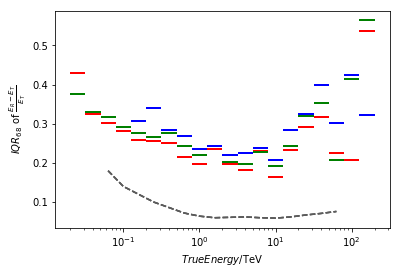

In [226]:
colors = {'LST': 'red', 'MST':'green', 'SST':'blue'}

for t in ['LST', 'MST', 'SST']:
    e_true = results['e_true_' + t]
    e_reco = results['e_reco_' + t]
    r2 = r2_score(e_true, e_reco)
    print(t, r2)
    plot_energy_resolution(e_true, e_reco, bins=bin_edges, color=colors[t])
#     ax.set_ylim([0, 0.45])
